# Importing necessary Library

In [1]:
import numpy as np
import os
import pickle
import pandas as pd
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LambdaCallback,EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import random
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

2023-04-02 20:53:12.159778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 20:53:12.430596: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/gwan/micromamba/envs/cs109b/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting sense of data

In [2]:
labels_dict = {0:'no', 1:'sphere', 2:'vort'}
folder_path = 'dataset/dataset/train/'
filepaths = []
label_values = []
for label, value in labels_dict.items():
    class_folder = os.path.join(folder_path, value + '/')
    for file in os.listdir(class_folder):
        if file.endswith('.npy'):
            filepaths.append(os.path.join(class_folder, file))
            label_values.append(label)
image = np.load(filepaths[0])
image.shape

(1, 150, 150)

In [3]:
image

array([[[0.01488834, 0.00992556, 0.00992556, ..., 0.00992556,
         0.00124069, 0.00372208],
        [0.01861042, 0.00992556, 0.00744417, ..., 0.00868486,
         0.01488834, 0.00496278],
        [0.00620347, 0.00868486, 0.00744417, ..., 0.01736973,
         0.00992556, 0.00744417],
        ...,
        [0.00620347, 0.01116625, 0.00496278, ..., 0.00992556,
         0.01116625, 0.00992556],
        [0.01116625, 0.00744417, 0.00992556, ..., 0.01488834,
         0.01488834, 0.00868486],
        [0.01240695, 0.01364764, 0.01488834, ..., 0.00744417,
         0.00992556, 0.01861042]]])

In [4]:
label_values[-5:]

[2, 2, 2, 2, 2]

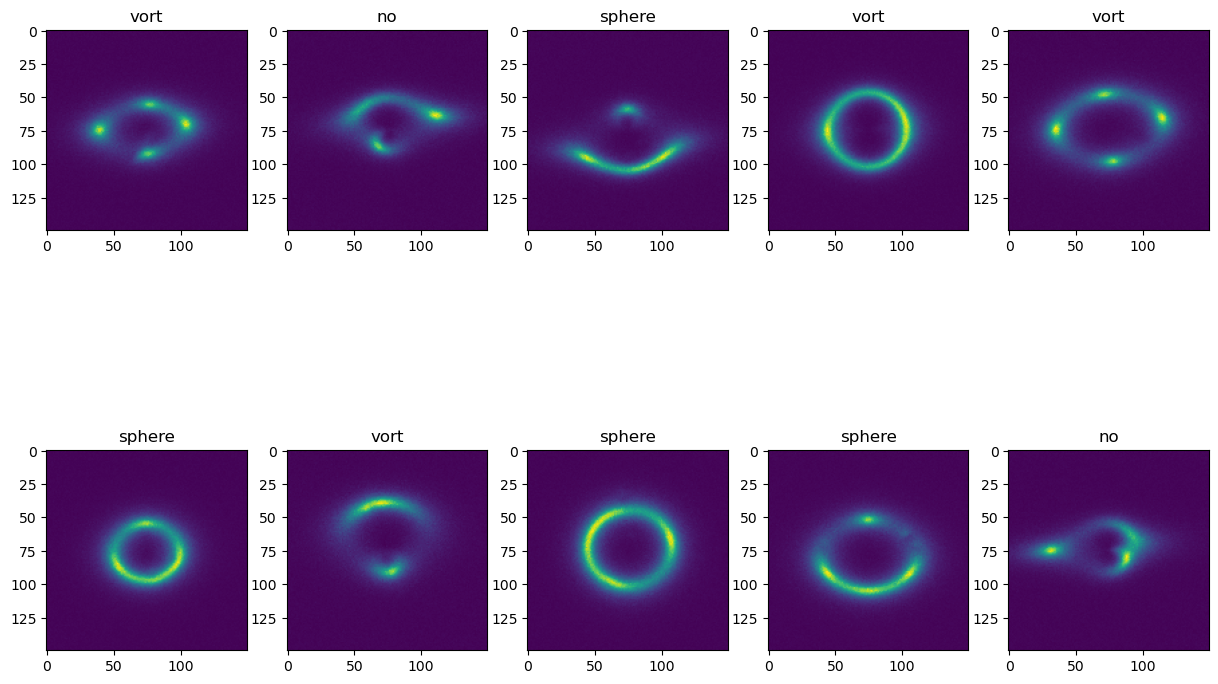

In [5]:
def plot_images(filepaths, labels, x, num_cols):
    num_rows = int(np.ceil(x / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    for i in range(x):
        # Randomly select an image from the filepaths list
        idx = np.random.randint(len(filepaths))
        filepath, label = filepaths[idx], labels[idx]
        
        # Load the image from the .npy file
        image = np.load(filepath)
        image = image.transpose(1, 2, 0)
        # Plot the image with its label as the title
        # Calculate the row and column index for this image
        row_idx = i // num_cols
        col_idx = i % num_cols
        
        # Plot the image with its label as the title
        axes[row_idx, col_idx].imshow(image)
        axes[row_idx, col_idx].set_title(labels_dict[labels[idx]])
    # Remove any unused subplot axes
    for i in range(x, num_rows*num_cols):
        row_idx = i // num_cols
        col_idx = i % num_cols
        axes[row_idx, col_idx].axis('off')        
    plt.show()
plot_images(filepaths, label_values, x=10, num_cols=5)

# Define HyperParameters

In [6]:
batch_size = 32
es_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [es_callback]
train_path = 'dataset/dataset/train/'
test_path = 'dataset/dataset/val/'
epochs = 100
do_train = False # If train

## Data Preprocessing

In [7]:
def get_filepaths_and_labels(folder_path):
    labels_dict = {0:'no', 1:'sphere', 2:'vort'}
    filepaths = []
    label_values = []
    for label, value in labels_dict.items():
        class_folder = os.path.join(folder_path, value + '/')
        for file in os.listdir(class_folder):
            if file.endswith('.npy'):
                filepaths.append(os.path.join(class_folder, file))
                label_values.append(label)
    random.seed(109)
    random.shuffle(filepaths)
    random.seed(109)
    random.shuffle(label_values)
    return filepaths, label_values
x_all, labels_all = get_filepaths_and_labels(train_path)
test_filepaths, test_labels = get_filepaths_and_labels(test_path)
train_filepaths, val_filepaths, train_labels, val_labels = train_test_split(x_all, labels_all, test_size=0.1, random_state=42)


train_files_ds = tf.data.Dataset.from_tensor_slices((train_filepaths,train_labels))
val_files_ds = tf.data.Dataset.from_tensor_slices((val_filepaths,val_labels))
test_files_ds = tf.data.Dataset.from_tensor_slices((test_filepaths, test_labels ))


def load_and_preprocess(file_path, label):
    data = np.load(file_path.numpy())
    data = data.transpose(1, 2, 0)
    data = np.repeat(data, 3, axis=-1)  # Convert the single channel to three channels
    return data.astype(np.float32), tf.one_hot(label, depth=3)

def load_and_preprocess_wrapper(file_path, label):
    return tf.py_function(load_and_preprocess, [file_path, label], [tf.float32, tf.float32])

def augment(image, label):

    # Apply random rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Apply random brightness
    image = tf.image.random_brightness(image, max_delta=0.05)

    # Apply random contrast
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)

    return image, label

# Apply augmentation to train_ds

train_ds = train_files_ds.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_files_ds.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_files_ds.map(load_and_preprocess_wrapper, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Print the number of examples in each set
print("Number of examples in the training set:", len(train_ds))
print("Number of examples in the validation set:", len(val_ds))
print("Number of examples in the test set:", len(test_ds))

2023-04-02 20:53:17.290499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-02 20:53:17.465257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-02 20:53:17.465690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-02 20:53:17.468454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FM

Number of examples in the training set: 27000
Number of examples in the validation set: 3000
Number of examples in the test set: 7500


In [8]:
def count_labels(data):
    label_counts = {}

    # Iterate through the dataset and count the occurrences of each label
    for x,y in data:
        label = labels_dict[int(tf.argmax(np.array(y)))]
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Print the label distribution
    for label, count in label_counts.items():
        print(f"Label {label} : {count} samples")
print("Label distribution (val):")
count_labels(val_ds)

Label distribution (val):
Label vort : 1023 samples
Label sphere : 1039 samples
Label no : 938 samples


In [9]:
print("Label distribution (test):")
count_labels(test_ds)

Label distribution (test):
Label no : 2500 samples
Label sphere : 2500 samples
Label vort : 2500 samples


## Simple CNN experiments

In [10]:
model_cnn = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

if do_train:
# Compile model
    model_cnn.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=[tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.AUC(curve='ROC', multi_label=True)])

    # Train model using generator

    history_cnn = model_cnn.fit(
            train_ds.batch(batch_size).prefetch(buffer_size = tf.data.experimental.AUTOTUNE),
            epochs=epochs,
            shuffle=True,
            callbacks = callbacks,
            validation_data=val_ds.batch(batch_size).prefetch(buffer_size = tf.data.experimental.AUTOTUNE),
        )
    # Save the model
    model_cnn.save('model_cnn.h5')

    # Save the history
    with open('history_cnn.pkl', 'wb') as file:
        pickle.dump(history_cnn.history, file)

# More complex model(transfer learning)

In [11]:
def Transfer_Learning_model(base_model):
    base_model.trainable = False
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # Add a global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)  # Regularize with dropout
    # A Dense classifier with a single unit (binary classification)
    outputs = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    return model
def Tranfer_Learning_training(base_model):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),
                       tf.keras.metrics.AUC(curve='ROC', multi_label=True)])

    # Train the model with the new layers for a few epochs
    initial_epochs = int(epochs * 0.2)
    history = model.fit(train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
                        epochs=initial_epochs,
                        shuffle = True,
                        callbacks=callbacks,
                        validation_data = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
    
    K.clear_session()
    base_model.trainable = True
# Compile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           tf.keras.metrics.AUC(curve='ROC', multi_label=True)])
    # Fine-tune the model for a few more epochs
    total_epochs = epochs

    history_fine = model.fit(train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE),
                             initial_epoch=initial_epochs,
                             epochs=total_epochs,
                             shuffle = True,
                             callbacks=callbacks,
                             validation_data = val_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
    return model,history_fine

## 1st Model (Fine Tuned Xception)

In [12]:
# Load the Xception model without the top layers
if do_train:
    base_model_1 = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model_1 = Transfer_Learning_training(base_model_1)
    model_xce,history_xce = Transfer_Learning_training(base_model_1)
    model_xce.save_weights('model_weights/xce_weights.h5')

    # Save the history
    with open('histories/history_xce_ft.pkl', 'wb') as file:
        pickle.dump(history_xce.history, file)

# 2nd Model, Fine Tuned DenseNet121 

In [13]:
if do_train:
    base_model_2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model_2 = Transfer_Learning_model(base_model_2)
    model_den,history_den = Transfer_Learning_training(base_model_2)
    # Save the model
    model_den.save_weights('model_weights/den_weights.h5')

    # Save the history
    with open('history_den.pkl', 'wb') as file:
        pickle.dump(history_den.history, file)

# 3rd Model Fine Tuned Res Net

In [14]:
if do_train:
    base_model_3 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
    base_model_3 = Transfer_Learning_model(base_model_3)
    model_res,history_res = Transfer_Learning_training(base_model_3)
    model_res.save_weights('model_weights/res_weights.h5')
    
    # Save the history
    with open('histories/history_res_ft.pkl', 'wb') as file:
        pickle.dump(history_res.history, file)

# Load and Summarlize model

In [15]:
def load_evaluate_summarize_model(model,weights_path, test_ds):
    # Load the model
    model.load_weights(weights_path)
    # Evaluate the model's performance
    test_labels = []
    test_probs = model.predict(test_ds.batch(batch_size=batch_size))

    for _, y_true in test_ds:
        test_labels.extend(y_true.numpy())
    
    num_classes = 3
    test_labels = np.array(test_labels).reshape((int(len(test_labels) / num_classes),num_classes))
    
    
    # Calculate RoC-Auc scores
    roc_auc_ovo = roc_auc_score(test_labels, test_probs, multi_class="ovo")
    roc_auc_ovr = roc_auc_score(test_labels, test_probs, multi_class="ovr")
    
    print("Test Results:")
    print(f"RoC-Auc OVO: {roc_auc_ovo}")
    print(f"RoC-Auc OVR: {roc_auc_ovr}")
    # Plot ROC-AUC curves for each class
    plt.figure()
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(test_labels[:, i], test_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# CNN

2023-04-02 20:53:48.740456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-04-02 20:54:05.724498: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  2/235 [..............................] - ETA: 13s    

2023-04-02 20:54:06.800391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


235/235 [==============================] - 38s 59ms/step
Test Results:
RoC-Auc OVO: 0.5
RoC-Auc OVR: 0.5


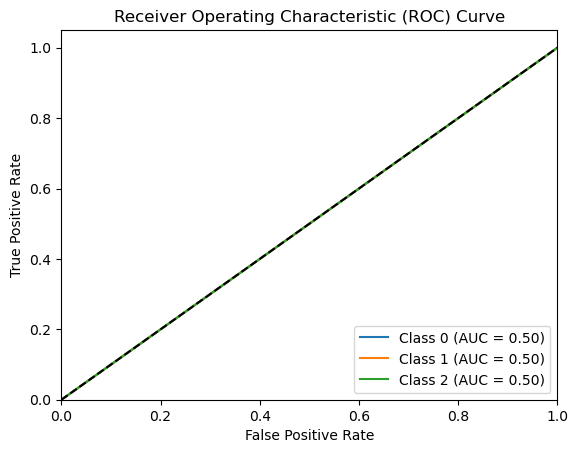

In [16]:
load_evaluate_summarize_model(model_cnn,'models/model_cnn.h5', test_ds)

# RESNET (Transfer Learning)

235/235 [==============================] - 21s 82ms/step
Test Results:
RoC-Auc OVO: 0.9886452666666666
RoC-Auc OVR: 0.9886452666666666


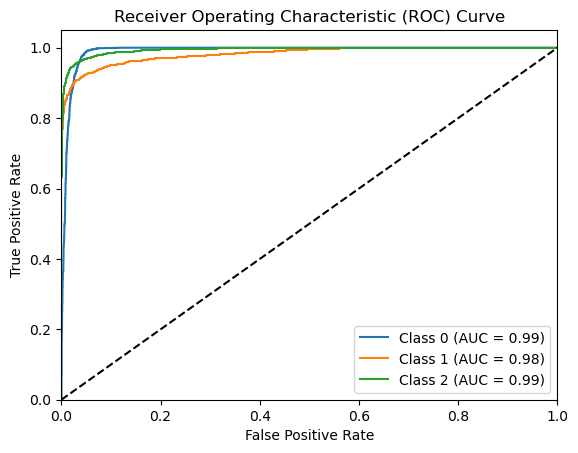

In [17]:
resnet = Transfer_Learning_model(ResNet50V2(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
load_evaluate_summarize_model(resnet,'model_weights/res_weights.h5', test_ds)

# Xception (Transfer Learning)

235/235 [==============================] - 21s 82ms/step
Test Results:
RoC-Auc OVO: 0.9818827333333333
RoC-Auc OVR: 0.9818827333333333


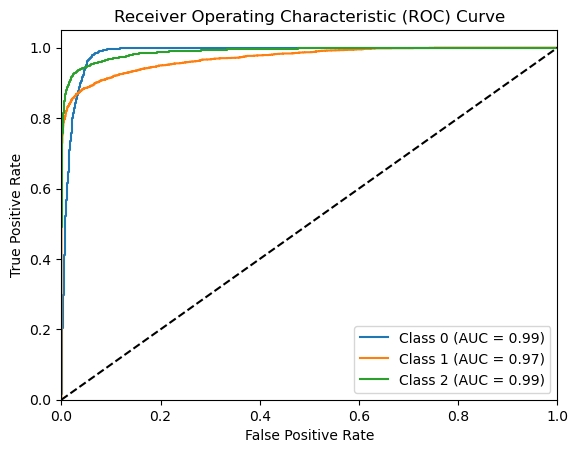

In [18]:
xception = Transfer_Learning_model(Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
load_evaluate_summarize_model(xception,'model_weights/xce_weights.h5', test_ds)

# Dense Net (Transfer Learning)

235/235 [==============================] - 24s 85ms/step
Test Results:
RoC-Auc OVO: 0.97738712
RoC-Auc OVR: 0.97738712


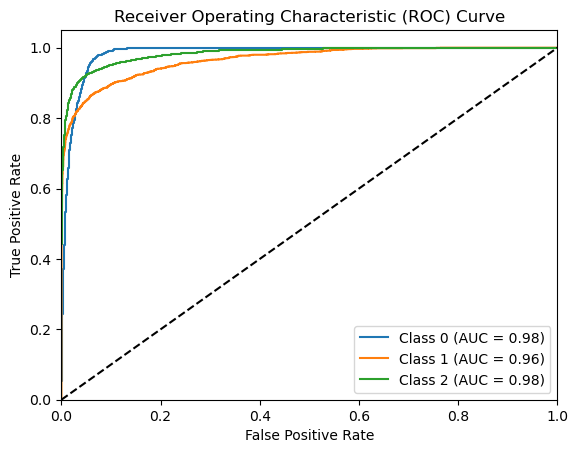

In [19]:
dense = Transfer_Learning_model(DenseNet121(weights='imagenet', include_top=False, input_shape=(150, 150, 3)))
load_evaluate_summarize_model(dense,'model_weights/den_weights.h5', test_ds)

# Visulize Best Model Histories

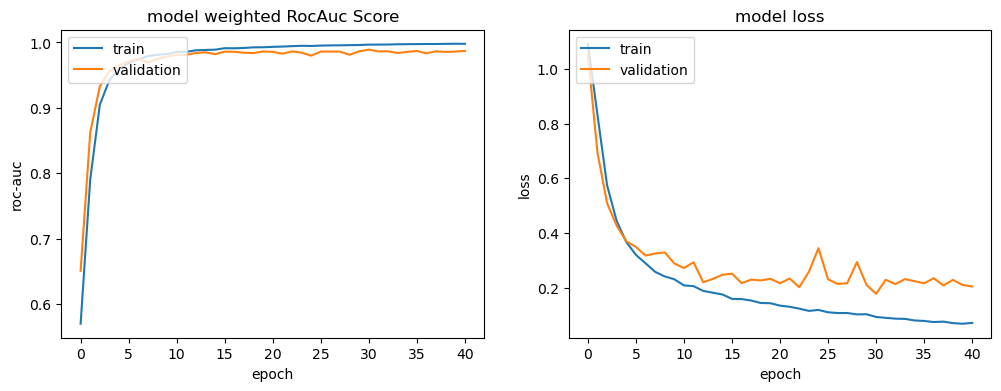

In [20]:
def plot_loss(model_history):
    """
    This helper function plots the NN model accuracy and loss.
    Arguments:
        model_history: the model history return from fit()
        out_file: the (optional) path to save the image file to.
    """
    fig, ax = plt.subplots(1, 2, figsize = (12, 4))
    
    history = model_history
    
    ax[0].plot(history['auc'])
    ax[0].plot(history['val_auc'])
    ax[0].set_title('model weighted RocAuc Score')
    ax[0].set_ylabel('roc-auc')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history['loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')
    plt.show()
    

best_history = pd.read_pickle(r'histories/history_res_ft.pkl')
plot_loss(model_history = best_history);